In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


Мы будем работать с данными агрегатора такси [Sigma Cabs](https://www.kaggle.com/datasets/arashnic/taxi-pricing-with-mobility-analytics). В зависимости от характеристик поездки требуется предсказать один из трех типов повышенного ценообразования: [1, 2, 3]. Таким образом, это поможет компании оптимально мэтчить такси и клиентов. 

In [29]:
df = pd.read_csv('sigma_cabs.csv')
df.shape

(131662, 14)

In [30]:
# Занесем индекс колонку
df = df.set_index('Trip_ID')
df.head()

,Trip_Distance,Type_of_Cab,Customer_Since_Months,Life_Style_Index,Confidence_Life_Style_Index,Destination_Type,Customer_Rating,Cancellation_Last_1Month,Var1,Var2,Var3,Gender,Surge_Pricing_Type
Trip_ID,,,,,,,,,,,,,
T0005689460,6.77,B,1.0,2.42769,A,A,3.90500,0,40.0,46,60,Female,2
T0005689461,29.47,B,10.0,2.78245,B,A,3.45000,0,38.0,56,78,Male,2
T0005689464,41.58,NaN,10.0,NaN,NaN,E,3.50125,2,NaN,56,77,Male,2
T0005689465,61.56,C,10.0,NaN,NaN,A,3.45375,0,NaN,52,74,Male,3
T0005689467,54.95,C,10.0,3.03453,B,A,3.40250,4,51.0,49,102,Male,2


Описание признаков:

1. **Trip_ID**: ID for TRIP
2. **Trip_Distance**: The distance for the trip requested by the customer
3. **TypeofCab**: Category of the cab requested by the customer
4. **CustomerSinceMonths**: Customer using cab services since n months; 0 month means current month
5. **LifeStyleIndex**: Proprietary index created by Sigma Cabs showing lifestyle of the customer based on their behaviour
6. **ConfidenceLifeStyle_Index**: Category showing confidence on the index mentioned above
7. **Destination_Type**: Sigma Cabs divides any destination in one of the 14 categories.
8. **Customer_Rating**: Average of life time ratings of the customer till date
9. **CancellationLast1Month**: Number of trips cancelled by the customer in last 1 month
10. **Var1**, **Var2** and **Var3**: Continuous variables masked by the company. Can be used for modelling purposes
11. **Gender**: Gender of the customer

**SurgePricingType**: Target (can be of 3 types)


### EDA 
Заполните пропуски в вещественных признаках медианой, а в категориальных - самым популярным классом. Изобразите марицу корреляций и выведите топ5 пар самых коррелированных признаков.

Так как в сумме уникальных значений различных категориальных признаков окажется не супер-много, примените `One-Hot-Encoding` для них. Не забудьте в методе `pd.get_dummies` указать параметр `drop_first=True`.

In [31]:
### Your code is here
df.isnull().sum()


Trip_Distance                      0
Type_of_Cab                    20210
Customer_Since_Months           5920
Life_Style_Index               20193
Confidence_Life_Style_Index    20193
Destination_Type                   0
Customer_Rating                    0
Cancellation_Last_1Month           0
Var1                           71030
Var2                               0
Var3                               0
Gender                             0
Surge_Pricing_Type                 0
dtype: int64

In [5]:
df['Confidence_Life_Style_Index'].mode()[0]

'B'

In [33]:
X_df = df.drop('Surge_Pricing_Type', axis=1)
num_cols = X_df.select_dtypes(include='number').columns

In [34]:
num_cols

Index(['Trip_Distance', 'Customer_Since_Months', 'Life_Style_Index',
       'Customer_Rating', 'Cancellation_Last_1Month', 'Var1', 'Var2', 'Var3'],
      dtype='object')

In [6]:
num_cols = df.select_dtypes(include='number').columns
cat_cols = df.select_dtypes(exclude='number').columns

df[num_cols] = df[num_cols].fillna(df[num_cols].median())

for col in cat_cols:
    df[col].fillna(df[col].mode()[0], inplace=True)

<Axes: >

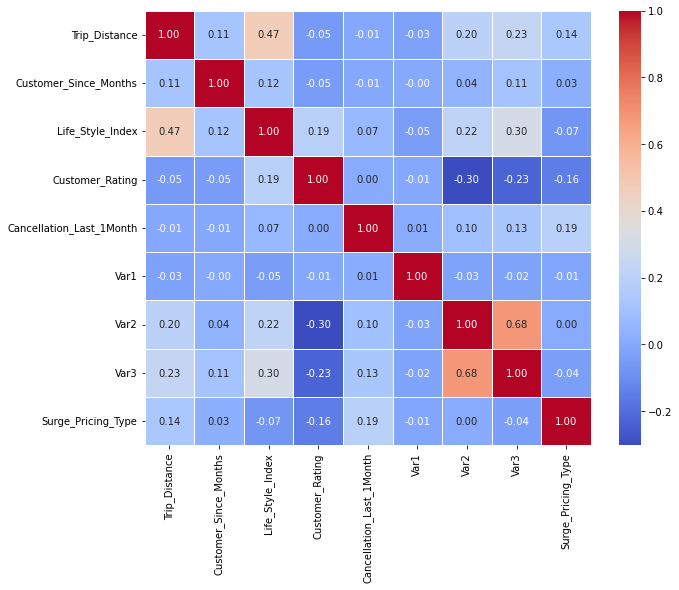

In [7]:
corr = df[num_cols].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)

In [8]:
top_corr = corr.unstack().sort_values(ascending=False).drop_duplicates().reset_index()
top_corr[top_corr['level_0'] != top_corr['level_1']].head()

,level_0,level_1,0
9,Var3,Var2,0.683437
10,Life_Style_Index,Trip_Distance,0.468332
11,Var3,Life_Style_Index,0.303324
12,Trip_Distance,Var3,0.231706
13,Life_Style_Index,Var2,0.215944


In [9]:
def get_redundant_pairs(df):
    pairs_to_drop = set()
    cols = df.columns
    for i in range(0, df.shape[1]):
        for j in range(0, i+1):
            pairs_to_drop.add((cols[i], cols[j]))
    return pairs_to_drop

def get_top_abs_correlations(df, n=5):
    au_corr = df.corr().abs().unstack()
    labels_to_drop = get_redundant_pairs(df)
    au_corr = au_corr.drop(labels=labels_to_drop).sort_values(ascending=False)
    return au_corr[0:n]

print("Top Absolute Correlations")
print(get_top_abs_correlations(df[num_cols], 10))

Top Absolute Correlations
Var2                      Var3                  0.683437
Trip_Distance             Life_Style_Index      0.468332
Life_Style_Index          Var3                  0.303324
Customer_Rating           Var2                  0.302968
Trip_Distance             Var3                  0.231706
Customer_Rating           Var3                  0.227531
Life_Style_Index          Var2                  0.215944
Trip_Distance             Var2                  0.200456
Life_Style_Index          Customer_Rating       0.189165
Cancellation_Last_1Month  Surge_Pricing_Type    0.185646
dtype: float64


In [10]:
df.shape

(131662, 13)

In [11]:
df = pd.get_dummies(df, columns=cat_cols, drop_first=True)

In [12]:
df.shape

(131662, 29)

### Training

In [13]:
np.random.seed(2022)

from sklearn.pipeline import Pipeline

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

In [14]:
X = df.drop('Surge_Pricing_Type', axis=1)
y = df['Surge_Pricing_Type']

In [15]:
X_train, X_test, y_train, y_test  = train_test_split(X, y, 
                                                     test_size=0.2, 
                                                     shuffle=True, 
                                                     random_state=2022)

**Задание 1.** Обучите One-vs-Rest Logreg. Не забудьте в шаг добавить стандартизацию данных (через `StandardScaler`) Посчитайте precision, recall, f1-score и усредните по всем классам с помощью micro, macro и weighted avg. Здесь и далее округляйте до 3 знака после запятой.

Чтобы отдельно и долго не вычислять метрики, можно воспользоваться `classification_report` из `sklearn.metrics`!

In [16]:
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression

### Your code is here
pipe = Pipeline([('scaler', StandardScaler()), 
                 ('one_vs_all', OneVsRestClassifier(LogisticRegression(C=0.001, penalty='l2')))])

pipe.fit(X_train, y_train)

Pipeline(steps=[('scaler', StandardScaler()),
                ('one_vs_all',
                 OneVsRestClassifier(estimator=LogisticRegression(C=0.001)))])

Подберите оптимальные гиперпараметры модели с помощью `GridSearchCV()` из предложенных. Для лучшего набора гиперпараметров посчитайте те же самые метрики. Валидировать параметры необходимо по `accuracy`. В этот раз проведем настояющую процедуру Кросс-Валидации! 

Для этого в метод `fit` передадим тренировочную часть наших данных, в параметр `cv` ничего не будем передавать (по дефолту 5-fold Кросс-Валидация будет проведена), а итоговые метрики замерим на тесте!

In [17]:
param_grid = {'one_vs_all__estimator__penalty': ['l1', 'l2', 'elasticnet'],
              'one_vs_all__estimator__C': [0.001, 0.01, 0.1, 1]}

In [18]:
from sklearn.model_selection import GridSearchCV

grid_search = GridSearchCV(pipe, param_grid)
grid_search.fit(X_train, y_train)


best_estimator = grid_search.best_estimator_
best_params = grid_search.best_params_

print(best_params)

{'one_vs_all__estimator__C': 0.001, 'one_vs_all__estimator__penalty': 'l2'}


In [19]:
### Your code is here
from sklearn.metrics import classification_report
y_pred = pipe.predict(X_test)

print(classification_report(y_test, y_pred, digits=3))


              precision    recall  f1-score   support

           1      0.742     0.534     0.621      5372
           2      0.635     0.839     0.723     11349
           3      0.742     0.576     0.649      9612

    accuracy                          0.681     26333
   macro avg      0.706     0.650     0.664     26333
weighted avg      0.696     0.681     0.675     26333



Изобразите три калибровочные кривые для Logistic Classifier: 0-vs-rest, 1-vs-rest, 2-vs-rest. Хорошо ли откалиброван обученный классификатор? 

Заметьте, что `predict_proba` возвращает список из вероятностей для всех наших классов!

In [20]:
### Your code is here

from sklearn.calibration import calibration_curve
from sklearn.calibration import CalibrationDisplay


### Your code is here
# CalibrationDisplay.from_estimator(pipe, X_test, y_test)

**Задание 2.** Обучите логистическую регрессию с гиперпараметрами из первого задания на полиномиальных признаках до 4 степени. Сравните метрики с первым заданием.


Пример: Пусть у нас был единственный признак 

$$
d_j = [1, 2, 3, 4]
$$

Тогда полиномиальные признаки до 4 степени от такого будут иметь вид:

$$
d_j^1 = [1, 2, 3, 4]
$$

$$
d_j^2 = [1, 4, 9, 16]
$$

$$
d_j^3 = [1, 8, 27, 64]
$$

$$
d_j^4 = [1, 16, 81, 256]
$$

P.S. Бинарные колонки нет смысла возводить в какие-то степени, поэтому возьмем исключительно вещественные из базовых. 

Для этого можно воспользоваться классическим циклом (или уроком из занятия про `Sberbank Housing Market`). Положите модифицированный датасет в переменную `X_polinomial`!

P.S.S Зачастую еще, создаваю полиномиальные фичи, учитывают "пересечения" признаков, то есть, например, из векторов признаков $d_j, d_i$ генерируют не просто новые степени $d_j^2, d_i^2, d_j^3, d_i^3...$, а еще и признаки вида $d_j \cdot d_i, d_j^2 \cdot d_i, d_j \cdot d_i^2...$, но здесь ограничьтесь просто степенями!

In [35]:
### Создание полиномиальных признаков

X_polinomial = X.copy()

### Your code is here
# from sklearn.preprocessing import PolynomialFeatures

# poly = PolynomialFeatures(degree=4, include_bias=False)
# poly_feat = poly.fit_transform(X_polinomial[num_cols])
# poly_df = pd.DataFrame(poly_feat, columns=poly.get_feature_names_out(num_cols))
# X_polinomial = pd.concat([X_polinomial, poly_df], axis=1)

numeric_df = X_polinomial[num_cols]

# Specify the degree of the polynomial
degree = 4

# Create a new dataframe to store polynomial features
poly_df = pd.DataFrame()

# Generate polynomial features for each numeric column up to the specified degree
for col in numeric_df.columns:
    for d in range(1, degree + 1):
        poly_col_name = f"{col}_degree_{d}"
        poly_df[poly_col_name] = numeric_df[col] ** d

# Concatenate the original dataframe with the polynomial features
X_poly_new = pd.concat([X_polinomial, poly_df], axis=1)

In [38]:
X_poly_new

,Trip_Distance,Customer_Since_Months,Life_Style_Index,Customer_Rating,Cancellation_Last_1Month,Var1,Var2,Var3,Type_of_Cab_B,Type_of_Cab_C,...,Var1_degree_3,Var1_degree_4,Var2_degree_1,Var2_degree_2,Var2_degree_3,Var2_degree_4,Var3_degree_1,Var3_degree_2,Var3_degree_3,Var3_degree_4
Trip_ID,,,,,,,,,,,,,,,,,,,,,
T0005689460,6.77,1.0,2.42769,3.90500,0,40.0,46,60,1,0,...,64000.0,2560000.0,46,2116,97336,4477456,60,3600,216000,12960000
T0005689461,29.47,10.0,2.78245,3.45000,0,38.0,56,78,1,0,...,54872.0,2085136.0,56,3136,175616,9834496,78,6084,474552,37015056
T0005689464,41.58,10.0,2.79805,3.50125,2,61.0,56,77,1,0,...,226981.0,13845841.0,56,3136,175616,9834496,77,5929,456533,35153041
T0005689465,61.56,10.0,2.79805,3.45375,0,61.0,52,74,0,1,...,226981.0,13845841.0,52,2704,140608,7311616,74,5476,405224,29986576
T0005689467,54.95,10.0,3.03453,3.40250,4,51.0,49,102,0,1,...,132651.0,6765201.0,49,2401,117649,5764801,102,10404,1061208,108243216
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
T0005908509,11.72,1.0,2.74229,3.28500,0,61.0,47,76,0,0,...,226981.0,13845841.0,47,2209,103823,4879681,76,5776,438976,33362176
T0005908510,74.81,7.0,2.81059,0.44500,0,61.0,63,88,0,1,...,226981.0,13845841.0,63,3969,250047,15752961,88,7744,681472,59969536
T0005908512,40.17,10.0,2.99565,3.33625,0,61.0,48,75,0,1,...,226981.0,13845841.0,48,2304,110592,5308416,75,5625,421875,31640625


In [39]:
X_pol_train, X_pol_test, y_train, y_test  = train_test_split(X_poly_new, y, 
                                                             test_size=0.2, 
                                                             shuffle=True, 
                                                             random_state=2022)

In [40]:
### Your code is here

pipe.fit(X_pol_train, y_train)
y_pred = pipe.predict(X_pol_test)

print(classification_report(y_test, y_pred, digits=3))

              precision    recall  f1-score   support

           1      0.750     0.532     0.623      5372
           2      0.637     0.835     0.722     11349
           3      0.740     0.587     0.655      9612

    accuracy                          0.683     26333
   macro avg      0.709     0.652     0.667     26333
weighted avg      0.697     0.683     0.677     26333



По аналогии с первым заданием изобразите три калибровочные кривые. Стало ли лучше?

In [ ]:
### Your code is here



**Задание 3.** Обучите на датасете без полиномиальных признаков One-vs-One `SGDClassifier` из `sklearn.linear_model`, который использует стохастический градиентный спуск (узнаете о нем позже) и может обучать как `SVM`, так и, например, `LogReg`, если указать в качестве параметра `loss` либо `hinge`, либо `log` соответственно!

Посчитайте precision, recall, f1-score и усредните по всем классам с помощью micro, macro и weighted avg.

In [41]:
X_train, X_test, y_train, y_test  = train_test_split(X, y, 
                                                     test_size=0.2, 
                                                     shuffle=True, 
                                                     random_state=2022)

In [45]:
from sklearn.linear_model import SGDClassifier
from sklearn.multiclass import OneVsOneClassifier

### Your code is here
pipe = Pipeline([('scaler', StandardScaler()), 
                 ('one_vs_one', OneVsOneClassifier(SGDClassifier(loss='hinge')))])

pipe.fit(X_train, y_train)

y_pred = pipe.predict(X_test)

print(classification_report(y_test, y_pred, digits=3))

              precision    recall  f1-score   support

           1      0.733     0.533     0.617      5372
           2      0.625     0.868     0.727     11349
           3      0.761     0.529     0.624      9612

    accuracy                          0.676     26333
   macro avg      0.707     0.643     0.656     26333
weighted avg      0.697     0.676     0.667     26333



Подберите оптимальные гиперпараметры модели с помощью `GridSearchCV()`. При этом переберите всевозможные функции потерь. Таким образом, при `loss = 'hinge'`, мы обучим SVM, при `loss = 'log'` мы обучим логистическую регрессию и т.д.

Используйте прием с Кросс-Валидацией при подборе параметров, как ранее, а также замерьте метрики на тесте.

In [46]:
param_grid = {'one_vs_one__estimator__loss': ['hinge', 'log', 'modified_huber'],
              'one_vs_one__estimator__penalty': ['l1', 'l2'],
              'one_vs_one__estimator__alpha': [0.001, 0.01, 0.1]}

In [47]:
### Your code is here
grid_search = GridSearchCV(pipe, param_grid)
grid_search.fit(X_train, y_train)


best_estimator = grid_search.best_estimator_
best_params = grid_search.best_params_

print(best_params)


{'one_vs_one__estimator__alpha': 0.1, 'one_vs_one__estimator__loss': 'modified_huber', 'one_vs_one__estimator__penalty': 'l2'}


In [48]:
pipe = Pipeline([('scaler', StandardScaler()), 
                 ('one_vs_one', OneVsOneClassifier(SGDClassifier(loss='modified_huber', alpha=0.1, penalty='l2')))])

pipe.fit(X_train, y_train)

y_pred = pipe.predict(X_test)

print(classification_report(y_test, y_pred, digits=3))

              precision    recall  f1-score   support

           1      0.747     0.529     0.620      5372
           2      0.633     0.844     0.723     11349
           3      0.744     0.572     0.647      9612

    accuracy                          0.681     26333
   macro avg      0.708     0.649     0.663     26333
weighted avg      0.697     0.681     0.674     26333



Можно ли однозначно сказать, какой подход оказался лучше: One-vs-Rest или One-vs-One?